# Loading the Dataset

In [2]:
import pandas as pd

In [34]:
movies_details_df = pd.read_json('IMDB_movie_details.json', lines=True)
display(movies_details_df.head())

reviews_df = pd.read_json('IMDB_reviews.json', lines=True)
display(reviews_df.head())

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Presentation of the Dataset

In [27]:
#TODO

# Preprocessing

## Tokenizer with regular expressions

In [6]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/lyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
imdb_spoilers_list = list(movies_details_df['plot_synopsis']) \
                    + list(movies_details_df['plot_summary']) \
                    + list(reviews_df['review_summary']) \
                    + list(reviews_df['review_text'])

imdb_spoilers_strings = " ".join(imdb_spoilers_list)

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize

# Have to reduce cause the len of `imdb_spoilers_strings` is 872 920 167 which way too big for my PC to tokenize (I might use Spark)
imdb_spoilers_strings_reduced = imdb_spoilers_strings[:1000000]
imdb_spoilers_tokens = word_tokenize(imdb_spoilers_strings_reduced) 

## Tokenizer with BPE

In [25]:
!pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable


In [19]:
import tiktoken

In [20]:
enc = tiktoken.encoding_for_model("gpt-4")
imdb_spoilers_tokens_bpe = enc.encode(imdb_spoilers_strings_reduced)

## Normalisation

### Deleting the stopwords && put in lowercase the words

In [21]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/lyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))
imdb_spoilers_tokens = [w.lower() for w in imdb_spoilers_tokens if not w.lower() in stop_words]

### Lemmatization : Changes the word to their inflected form (sleeping -> sleep)

In [23]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/lyes/nltk_data...


True

In [24]:
lemmatizer = WordNetLemmatizer()
imdb_spoilers_tokens = [lemmatizer.lemmatize(w) for w in imdb_spoilers_tokens]

# Descriptive statistics

# Training on several predictive models

## Setup the dataFrame for the predictive models

Which part contains spoilers ?

1. Plot summary : Does not contain spoiler
2. Plot synopsis: Contains Spoiler

In [35]:
# Cleaning the plot_synopsis column
plot_synopsis = movies_details_df.loc[movies_details_df['plot_synopsis'] != '', 'plot_synopsis']

# Outputs the length of the 2 category
no_spoil_length = len(movies_details_df['plot_summary'])
spoil_length = len(plot_synopsis)

# Create the appropriate dataFrame for ours models : Text - Is Spoil
all_texts = pd.concat([movies_details_df['plot_summary'], plot_synopsis])
spoil_categories = [False] * no_spoil_length + [True] * spoil_length
is_spoiler_df = pd.DataFrame({'text': all_texts, 'is_spoiler': spoil_categories})

# Clean the reviews df to make it more appropriate
reviews_df = reviews_df[['review_text', 'is_spoiler']]
reviews_df = reviews_df.rename(columns={'review_text': 'text'})

# Concat the two df
is_spoiler_df = pd.concat([reviews_df, is_spoiler_df], axis=0, ignore_index=True)

is_spoiler_df

,text,is_spoiler
0,"In its Oscar year, Shawshank Redemption (writt...",True
1,The Shawshank Redemption is without a doubt on...,True
2,I believe that this film is the best story eve...,True
3,"**Yes, there are SPOILERS here**This film has ...",True
4,At the heart of this extraordinary movie is a ...,True
...,...,...
576819,The film opens with a homeless man (Bud Cort) ...,True
576820,Will Freeman (Hugh Grant) is a 38-year-old bac...,True
576821,"In the year 1998, Evan Treborn (Ashton Kutcher...",True
576822,"Brandon (Michael Fassbender) is a successful, ...",True


In [36]:
from sklearn.model_selection import train_test_split

X = is_spoiler_df['text']
y = is_spoiler_df['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [37]:
y_train

275275     True
369869    False
155460    False
498151    False
250669    False
          ...  
110268    False
259178    False
365838     True
131932    False
121958     True
Name: is_spoiler, Length: 461459, dtype: bool

In [55]:
test_spoilers = [
    "Lyes meurt à la fin",
    "Bruce Willis était mort depuis le début dans 'The Sixth Sense' !",
    "Dark Vador était le père de Luke depuis le début ! C'est incroyable !",
    "La mort de Hank à la fin de 'Breaking Bad' était tellement inattendue. J'étais complètement choqué.",
    "Verbal Kint est en réalité Keyser Söze dans 'The Usual Suspects' ! C'est tellement bien fait."
]

def testsuite(model, test_spoilers):
    for spoiler in test_spoilers:
        print(f"{spoiler} --> Spoiler : {model.predict([spoiler])}")

## Bayesian Model

### Training our model

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

In [91]:
ngram_range = (1,1) # Choose the way you would to train the model : Hyper Parameter
model = make_pipeline(CountVectorizer(ngram_range = ngram_range), MultinomialNB())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Evaluation of our model

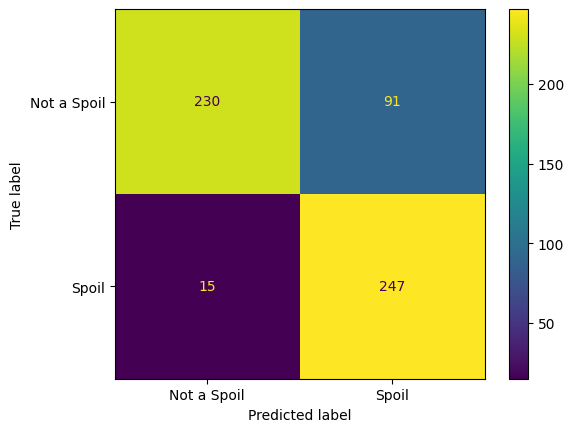

In [93]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Logistic Regression

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

In [48]:
model = make_pipeline(CountVectorizer(stop_words="english"), TfidfTransformer(), LogisticRegression(random_state=42, max_iter = 1000))


cross_val_predict(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

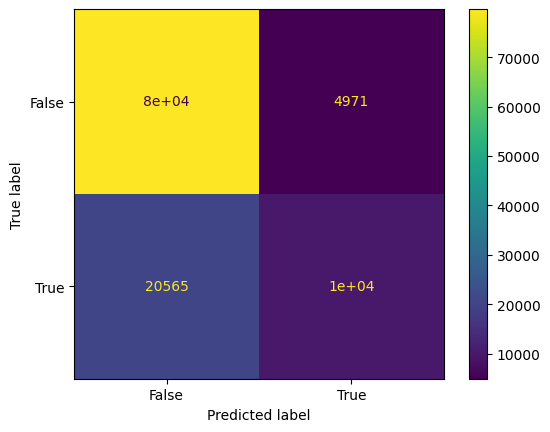

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [56]:
testsuite(model,test_spoilers)

Lyes meurt à la fin --> Spoiler : [False]
Bruce Willis était mort depuis le début dans 'The Sixth Sense' ! --> Spoiler : [False]
Dark Vador était le père de Luke depuis le début ! C'est incroyable ! --> Spoiler : [False]
La mort de Hank à la fin de 'Breaking Bad' était tellement inattendue. J'étais complètement choqué. --> Spoiler : [False]
Verbal Kint est en réalité Keyser Söze dans 'The Usual Suspects' ! C'est tellement bien fait. --> Spoiler : [False]


In [54]:
model.predict(["Spoiler"])

array([ True])